### Import libraries and features 

In [2]:
import umap
from pynndescent import NNDescent
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [5]:
training,testing = train_test_dfs(train,dev,test,"Class",0.1,1988)

### Create manifold features and see how well it generalizes to test class

In [6]:
def plot_umap(embed,title,target):
    plt.figure(figsize=(12,7),dpi=150)
    cdict = {0:"yellow",1:"purple"}
    n_ind = np.where(target==0)
    f_ind = np.where(target==1)
    plt.scatter(embed.T[0,n_ind],embed.T[1,n_ind],s=1,c=cdict[0],label="normal",cmap="viridis")
    plt.scatter(embed.T[0,f_ind],embed.T[1,f_ind],s=3,c=cdict[1],label="fraud",cmap="viridis")
    plt.title(title)
    plt.legend(fontsize=12,markerscale=3)
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

In [7]:
X, y = training.drop("Class",axis=1), training.Class

In [8]:
X_test, y_test = testing.drop("Class",axis=1), testing.Class

In [9]:
feature_map = umap.UMAP().fit(X,y)

In [10]:
train_embed = feature_map.transform(X)
test_embed = feature_map.transform(X_test)

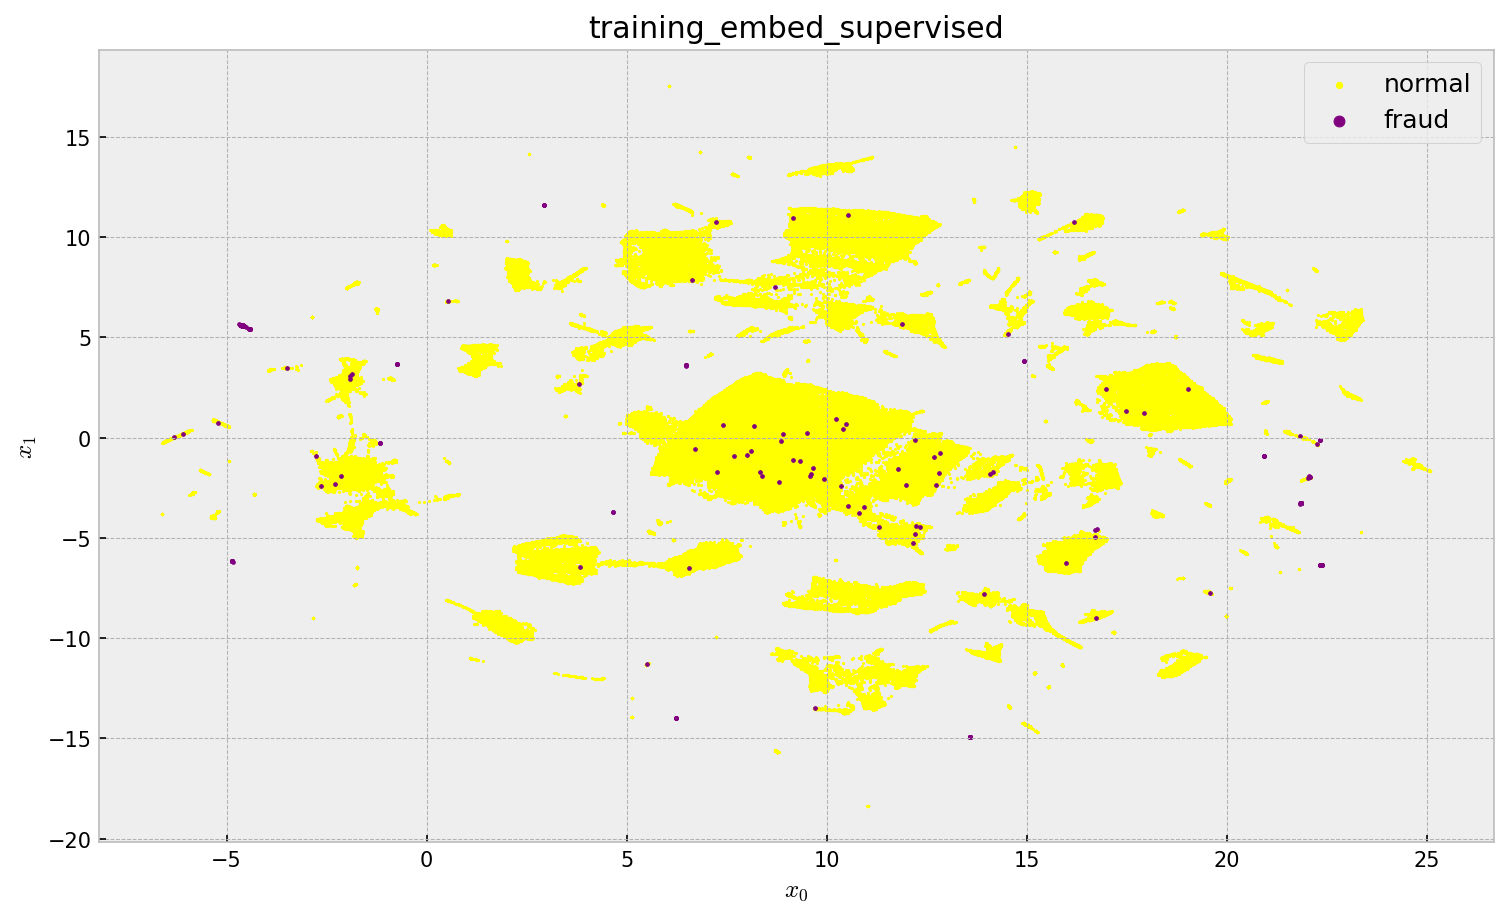

In [11]:
plot_umap(train_embed,"training_embed_supervised",y)

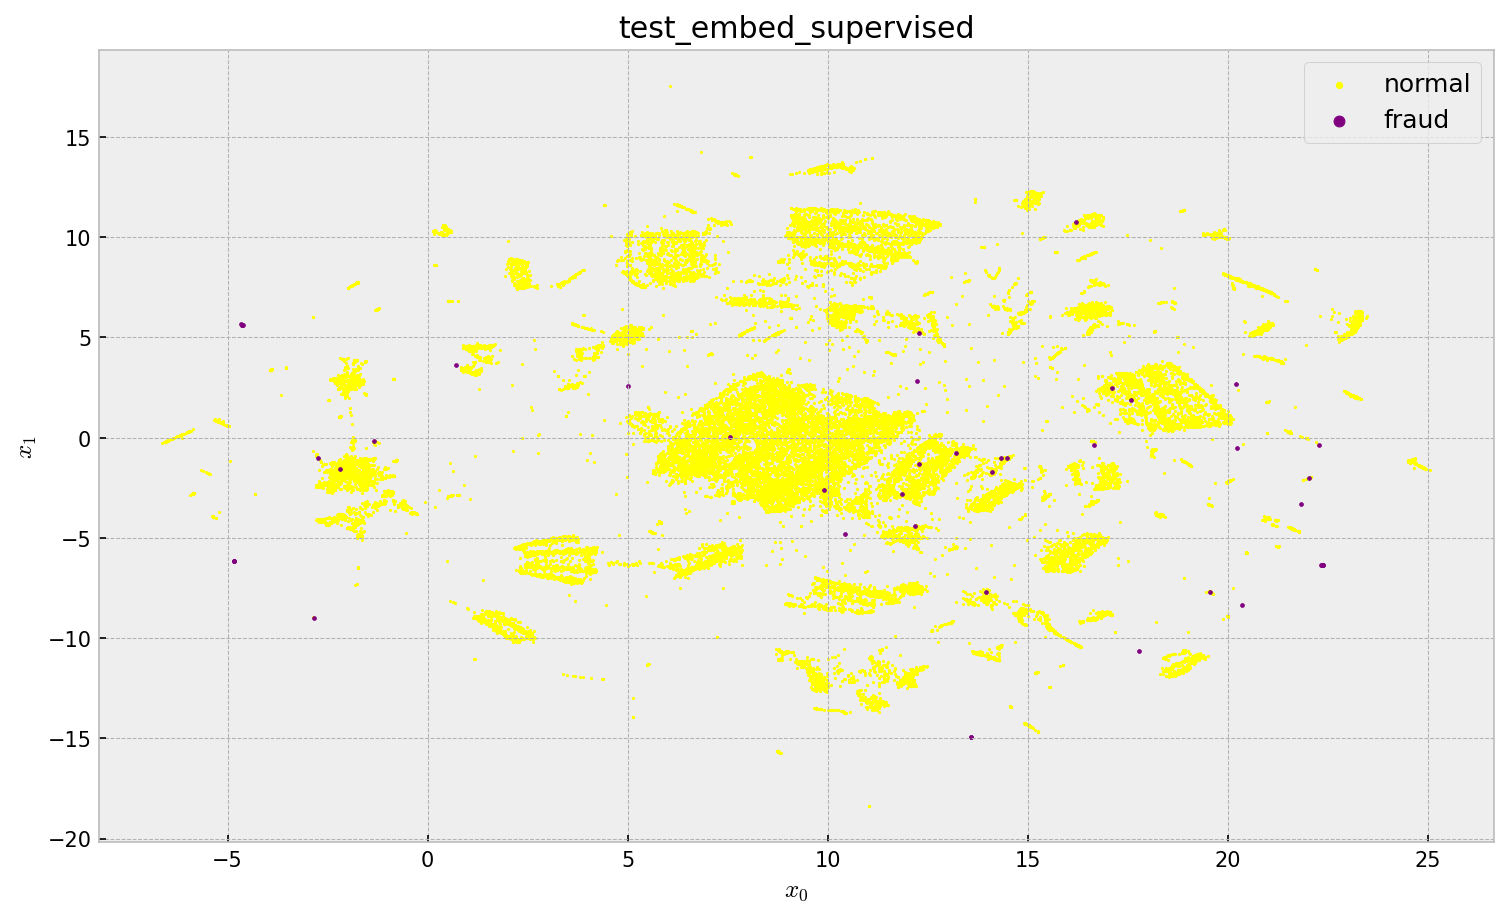

In [12]:
plot_umap(test_embed,"test_embed_supervised",y_test)

### Very similar however not very good separation in 2 d

### simple model with original features

In [13]:
lg_1 = LogisticRegression(n_jobs = 20, random_state=20)

In [14]:
lg_1.fit(X,y)

LogisticRegression(n_jobs=20, random_state=20)

In [15]:
pred_1 = lg_1.predict_proba(X_test)[:,1]

In [77]:
output_1 = model_results(y_test,pred_1,threshold=0.1,ifprint=True)

[[28426     6]
 [    9    40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.87      0.82      0.84        49

    accuracy                           1.00     28481
   macro avg       0.93      0.91      0.92     28481
weighted avg       1.00      1.00      1.00     28481



### simple model with umap transformatoin and see if it helps

In [17]:
lg_2 = LogisticRegression(n_jobs = 20, random_state=20)

In [18]:
trans = umap.UMAP(n_neighbors=20, random_state=42).fit(X)

In [19]:
train_embed = trans.transform(X)
test_embed = trans.transform(X_test)

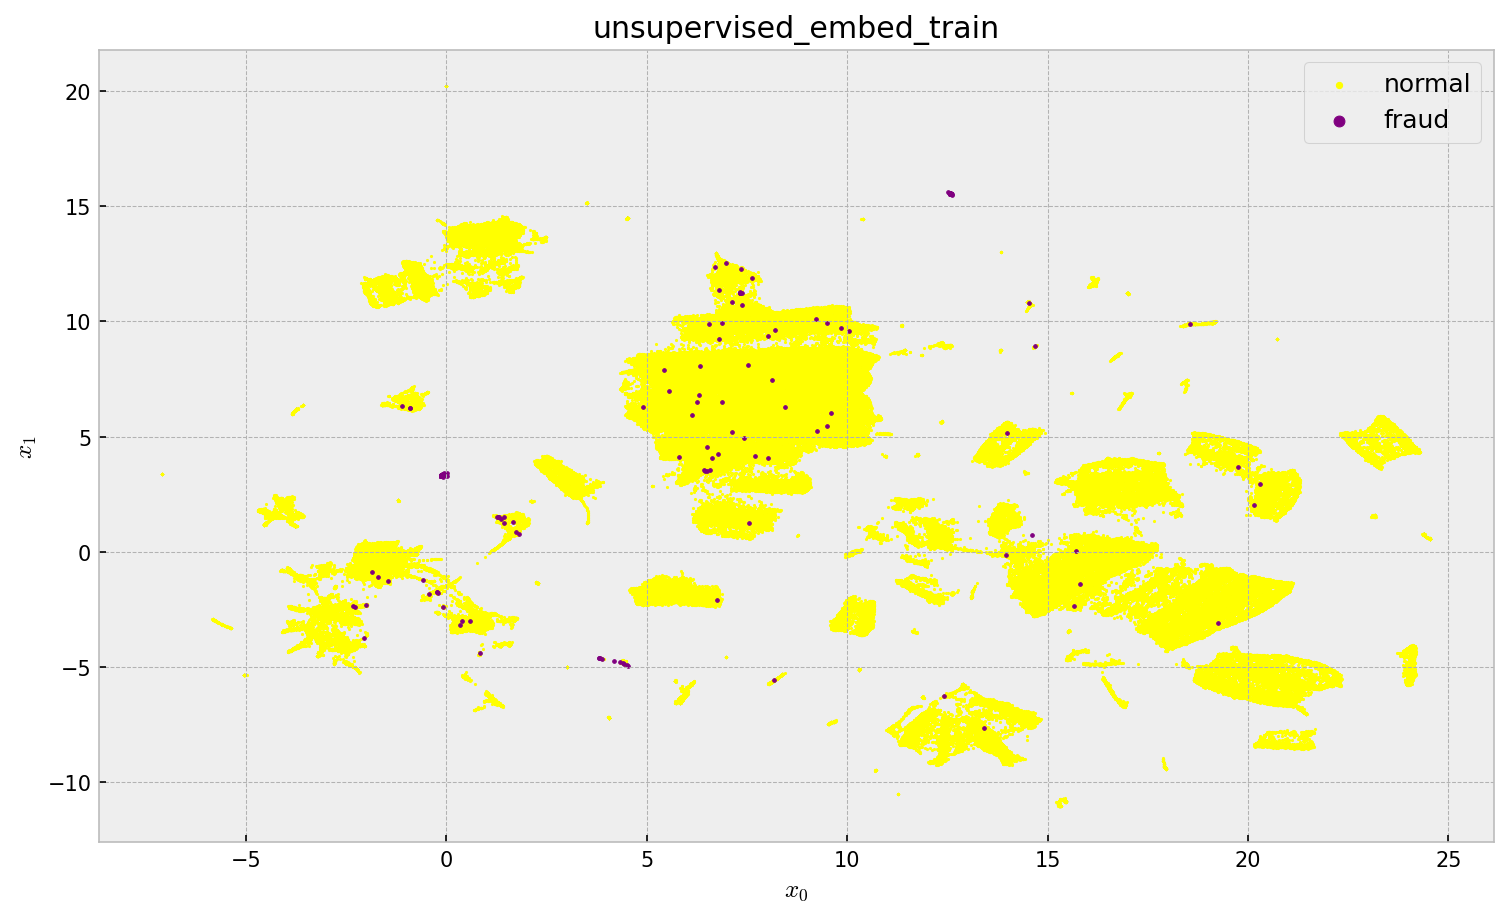

In [21]:
plot_umap(train_embed,"unsupervised_embed_train",y)

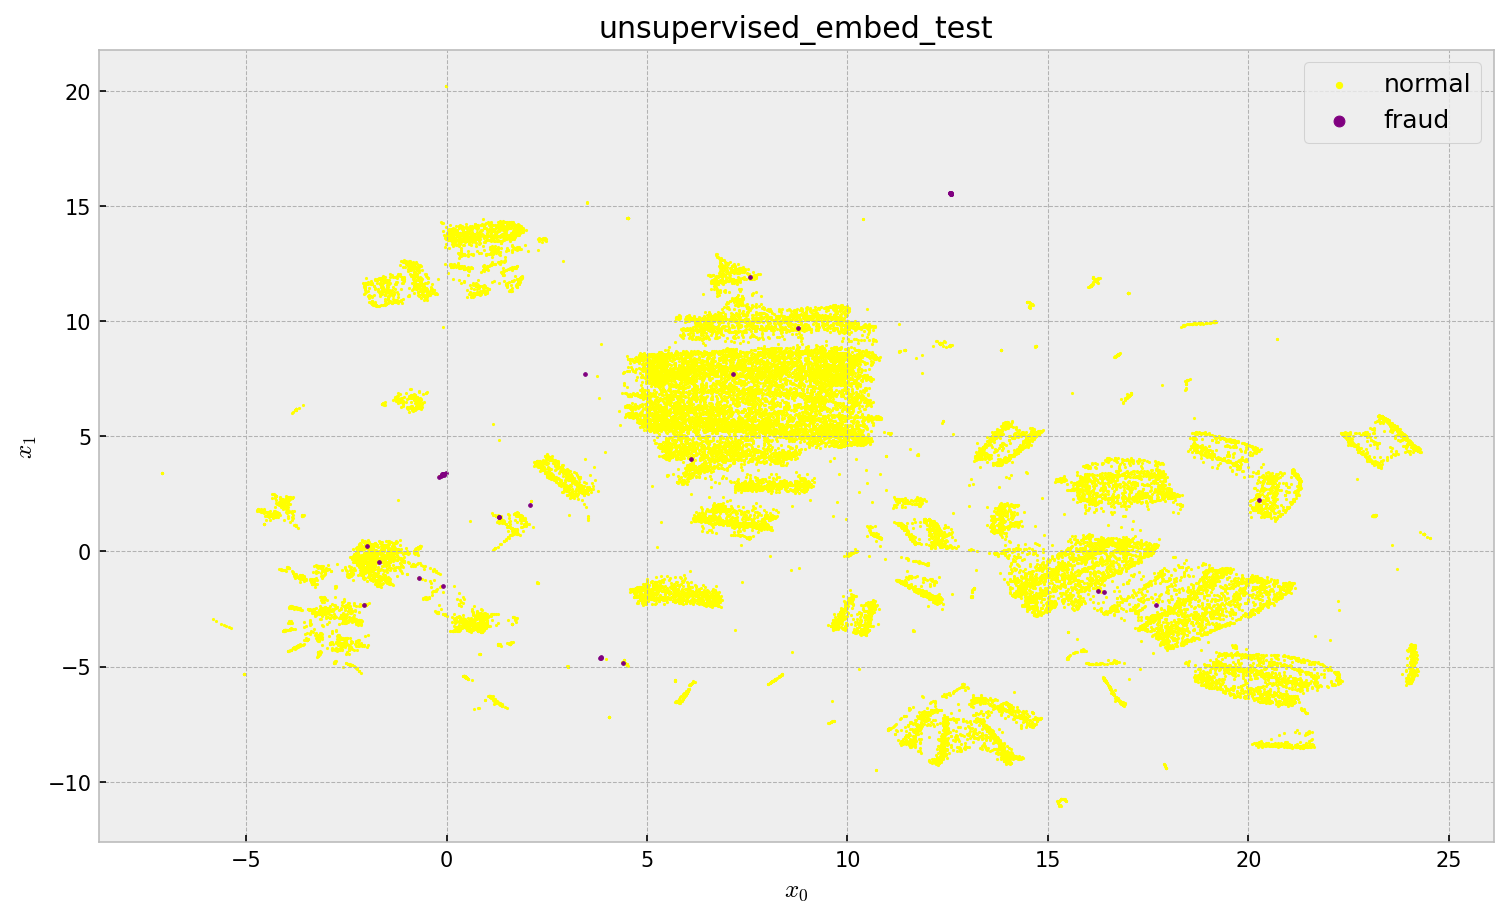

In [23]:
plot_umap(test_embed,"unsupervised_embed_test",y_test)

In [24]:
lg_2.fit(train_embed,y)

LogisticRegression(n_jobs=20, random_state=20)

In [26]:
pred_2 = lg_2.predict_proba(test_embed)[:,1]

In [73]:
output_2 = model_results(y_test,pred_2,threshold=0.1,ifprint=True)

[[28432     0]
 [   49     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.00      0.00      0.00        49

    accuracy                           1.00     28481
   macro avg       0.50      0.50      0.50     28481
weighted avg       1.00      1.00      1.00     28481



### let's try the embedding via an tree model 

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

In [29]:
tree = ExtraTreesClassifier(n_jobs = 20)
tree.fit(X,y)

ExtraTreesClassifier(n_jobs=20)

In [90]:
output = model_results(y_test,tree.predict_proba(X_test)[:,1],threshold=0.12,ifprint=True)

[[28425     7]
 [    5    44]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.90      0.88        49

    accuracy                           1.00     28481
   macro avg       0.93      0.95      0.94     28481
weighted avg       1.00      1.00      1.00     28481



In [31]:
leaves = tree.apply(X)

In [33]:
test_leaves = tree.apply(X_test)

In [32]:
sup_embed_tree = umap.UMAP(metric="hamming").fit(leaves)

In [35]:
train_embed = sup_embed_tree.transform(leaves)
test_embed = sup_embed_tree.transform(test_leaves)

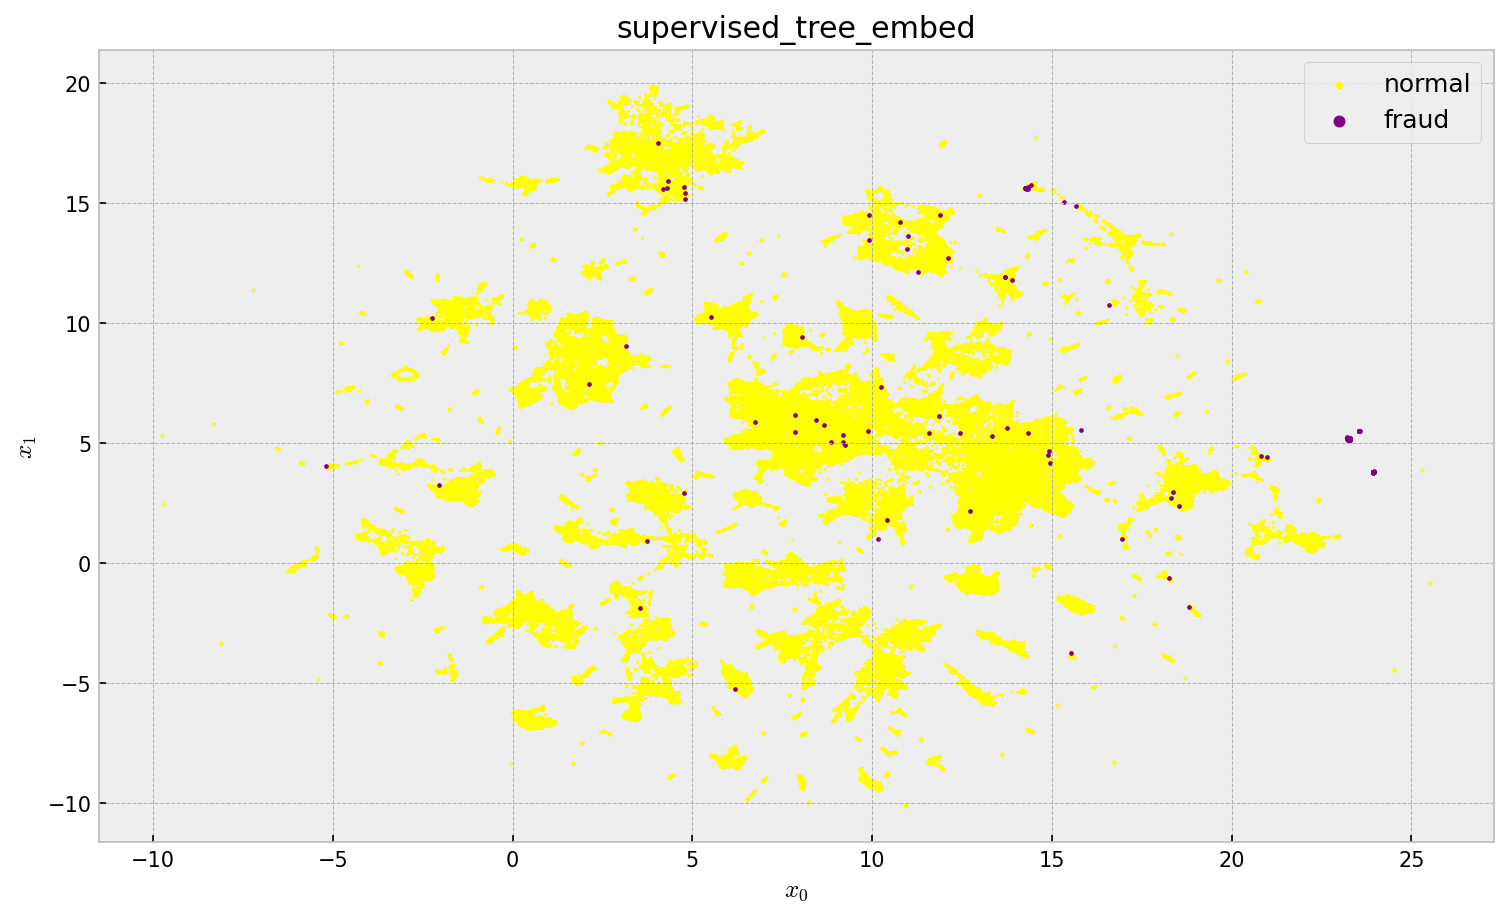

In [36]:
plot_umap(train_embed,"supervised_tree_embed",y)

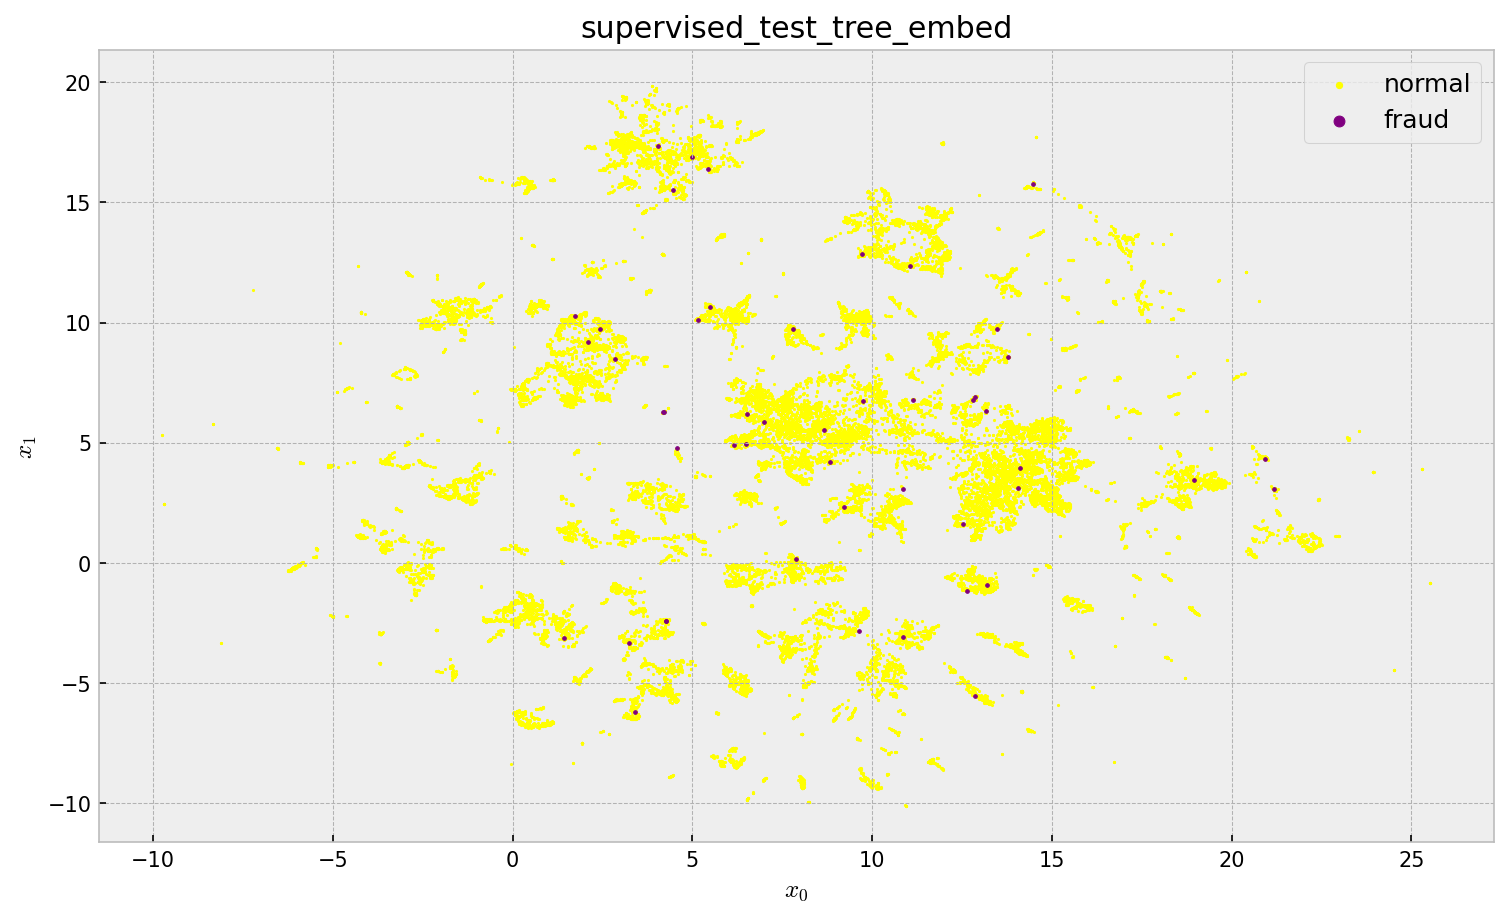

In [37]:
plot_umap(train_embed,"supervised_test_tree_embed",y_test)

In [38]:
lg_3 = LogisticRegression(n_jobs = 20, random_state=20)

In [39]:
lg_3.fit(train_embed,y)

LogisticRegression(n_jobs=20, random_state=20)

In [40]:
pred_3 = lg_3.predict_proba(test_embed)[:,1]

In [79]:
output_3 = model_results(y_test,pred_3,threshold=0.3,ifprint=True)

[[28422    10]
 [   12    37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.79      0.76      0.77        49

    accuracy                           1.00     28481
   macro avg       0.89      0.88      0.89     28481
weighted avg       1.00      1.00      1.00     28481



### Improve with tree leaves embedding but maybe 2D features are not capturing everything based upon the images